In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import itertools
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings

In [2]:
warnings.filterwarnings("ignore")

Lets read in our dataset

In [3]:
df = pd.read_csv('merged.csv', index_col = 0)
df.DateTime = pd.to_datetime(df.DateTime)
df.head()

,DateTime,Junction,Vehicles,Hour,Vehicles_previous_hour,Vehicles_previous_2hours,Vehicles_previous_3hours,Vehicles_previous_4hours,Vehicles_previous_5hours,Vehicles_previous_6hours,Vehicles_previous_12hours,Vehicles_previous_day,tempC,precipMM,humidity,windspeedKmph,Event_Name,Event_Type
0,2015-11-01 00:00:00,1,0.083333,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.296296,0.0,0.923077,0.205128,No events,No events
1,2015-11-01 00:00:00,2,0.033333,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.296296,0.0,0.923077,0.205128,No events,No events
2,2015-11-01 00:00:00,3,0.050000,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.296296,0.0,0.923077,0.205128,No events,No events
3,2015-11-01 00:00:00,4,0.000000,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.296296,0.0,0.923077,0.205128,No events,No events
4,2015-11-01 01:00:00,1,0.072222,1,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.296296,0.0,0.934066,0.205128,No events,No events


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58368 entries, 0 to 58367
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   58368 non-null  datetime64[ns]
 1   Junction                   58368 non-null  int64         
 2   Vehicles                   58368 non-null  float64       
 3   Hour                       58368 non-null  int64         
 4   Vehicles_previous_hour     58368 non-null  float64       
 5   Vehicles_previous_2hours   58368 non-null  float64       
 6   Vehicles_previous_3hours   58368 non-null  float64       
 7   Vehicles_previous_4hours   58368 non-null  float64       
 8   Vehicles_previous_5hours   58368 non-null  float64       
 9   Vehicles_previous_6hours   58368 non-null  float64       
 10  Vehicles_previous_12hours  58368 non-null  float64       
 11  Vehicles_previous_day      58368 non-null  float64       
 12  tempC    

Let split our data into training data and testing data. We should ensure that the data is not shuffled, which is crucial in preserving the sequence of events.

In [5]:
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

LSTMs (Long Short-Term Memory networks) are specifically designed to handle sequential data and time series data effectively. They can capture long-term dependencies and patterns in our data, which is crucial for predicting traffic congestion that might depend on previous time steps.

LSTMs are capable of modeling complex non-linear relationships in our data. Traffic congestion can be influenced by various non-linear factors such as weather conditions, special events, and time of day. LSTMs can capture these intricate patterns better than linear models like ARIMA. 

ARIMA is a linear model, which makes it less capable of capturing complex non-linear relationships in the data. Traffic congestion can be influenced by non-linear factors like varying weather conditions, special events, and unpredictable traffic patterns, which ARIMA might not model well. While ARIMA is good at capturing short-term dependencies in time series data, it might not capture long-term dependencies as effectively as LSTMs.


We will use an ARIMA and LSTM model to forecast traffic congestion using our data and compare the two models.

Lets begin with the ARIMA model. Lets define the p, d, q parameters to take any value between 0 and 2

In [6]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

Grid Search for ARIMA hyperparameters

In [7]:
best_aic = float("inf")
best_order = None

for param in pdq:
    try:
        temp_model = ARIMA(train_data['Vehicles'], order=param)
        temp_model_fit = temp_model.fit()
        if temp_model_fit.aic < best_aic:
            best_aic = temp_model_fit.aic
            best_order = param
    except:
        continue
        print('Except')

print(f'Best order: {best_order} || AIC: {best_aic}')

Best order: (1, 0, 2) || AIC: -119233.52056194498


Train the best ARIMA model

In [8]:
final_arima_model = ARIMA(train_data['Vehicles'], order=best_order)
final_arima_model_fit = final_arima_model.fit()

Lets forecast with the ARIMA model

In [9]:
arima_forecast = final_arima_model_fit.forecast(steps=len(test_data))

LSTM model

Lets use grid search to find the optimal configuration for the LSTM model.

Data preperation for LSTM

In [10]:
X_train = train_data[['Vehicles_previous_hour', 'Vehicles_previous_2hours', 'Vehicles_previous_3hours', 'Vehicles_previous_4hours', 'Vehicles_previous_5hours', 'Vehicles_previous_6hours', 'Vehicles_previous_12hours', 'Vehicles_previous_day', 'tempC', 'precipMM', 'humidity', 'windspeedKmph']].values
y_train = train_data['Vehicles'].values
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

X_test = test_data[['Vehicles_previous_hour', 'Vehicles_previous_2hours', 'Vehicles_previous_3hours', 'Vehicles_previous_4hours', 'Vehicles_previous_5hours', 'Vehicles_previous_6hours', 'Vehicles_previous_12hours', 'Vehicles_previous_day', 'tempC', 'precipMM', 'humidity', 'windspeedKmph']].values
y_test = test_data['Vehicles'].values
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Lets define LSTM model creation function

In [11]:
def create_lstm_model(units=50):
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

Keras Regressor for LSTM

In [12]:
model = KerasRegressor(build_fn=create_lstm_model, verbose=0)

Grid Search for LSTM hyperparameters

In [13]:
param_grid = {
    'units': [50, 100, 150],
    'batch_size': [32, 64, 128],
    'epochs': [10, 50, 100]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_result = grid.fit(X_train, y_train)

Best hyperparameters for LSTM

In [ ]:
best_params = grid_result.best_params_
print(f'Best LSTM params: {best_params}')

Create and train the final LSTM model

In [15]:
final_lstm_model = create_lstm_model(units=best_params['units'])
final_lstm_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0, validation_data=(X_test, y_test))

Predict with LSTM

In [16]:
lstm_predictions = final_lstm_model.predict(X_test)
lstm_predictions = pd.Series([i[0] for i in lstm_predictions.tolist()], index = test_data.index)

365/365 [==============================] - 1s 2ms/step


Lets evaluate the models

In [17]:
# Evaluation metrics for ARIMA
mae_arima = mean_absolute_error(test_data['Vehicles'], arima_forecast)
rmse_arima = np.sqrt(mean_squared_error(test_data['Vehicles'], arima_forecast))

# Evaluation metrics for LSTM
mae_lstm = mean_absolute_error(y_test, lstm_predictions)
rmse_lstm = np.sqrt(mean_squared_error(y_test, lstm_predictions))

print(f'ARIMA MAE: {mae_arima}, RMSE: {rmse_arima}')
print(f'LSTM MAE: {mae_lstm}, RMSE: {rmse_lstm}')

ARIMA MAE: 0.10593116221037163, RMSE: 0.16370842274637812
LSTM MAE: 0.01693246693513671, RMSE: 0.025762683358332095


The LSTM model has a significantly lower MAE, indicating that its predictions are, on average, only 0.016 units off from the actual values. This reflects a higher accuracy compared to ARIMA. The RMSE for the LSTM model is also much lower, suggesting that it has a smaller and more concentrated error distribution compared to ARIMA.

The LSTM model outperforms the ARIMA model in both MAE and RMSE, indicating that it provides more accurate predictions with less deviation from the actual values.

The lower MAE and RMSE of the LSTM model suggest it captures the patterns in the data more effectively than the ARIMA model, making it a better choice for this forecasting task.

Lets visualize the models' predictions

Prediction vs. Actual Plots

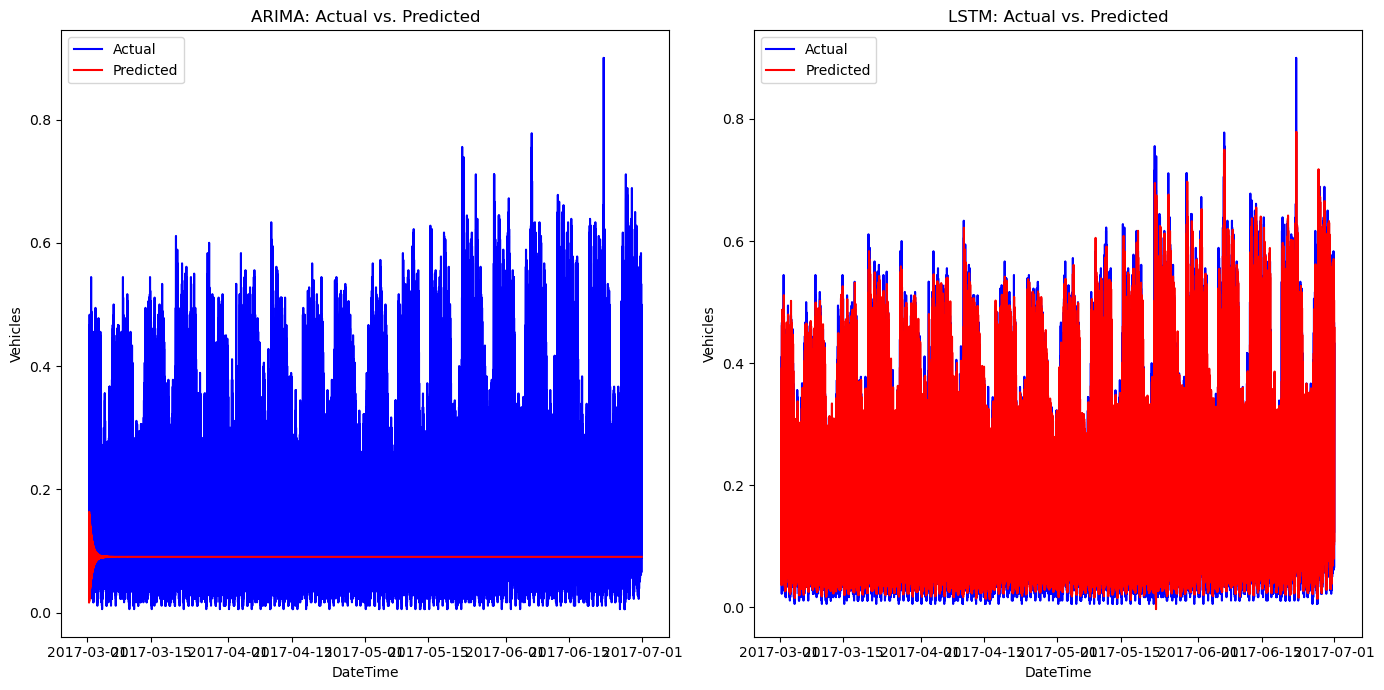

In [18]:
plt.figure(figsize=(14, 7))

# For ARIMA
plt.subplot(1, 2, 1)
plt.plot(test_data.DateTime, test_data['Vehicles'], label='Actual', color='blue')
plt.plot(test_data.DateTime, arima_forecast, label='Predicted', color='red')
plt.title('ARIMA: Actual vs. Predicted')
plt.xlabel('DateTime')
plt.ylabel('Vehicles')
plt.legend()

# For LSTM
plt.subplot(1, 2, 2)
plt.plot(test_data.DateTime[-len(y_test):], y_test, label='Actual', color='blue')
plt.plot(test_data.DateTime[-len(y_test):], lstm_predictions, label='Predicted', color='red')
plt.title('LSTM: Actual vs. Predicted')
plt.xlabel('DateTime')
plt.ylabel('Vehicles')
plt.legend()

plt.tight_layout()
plt.show()


Residual Plots

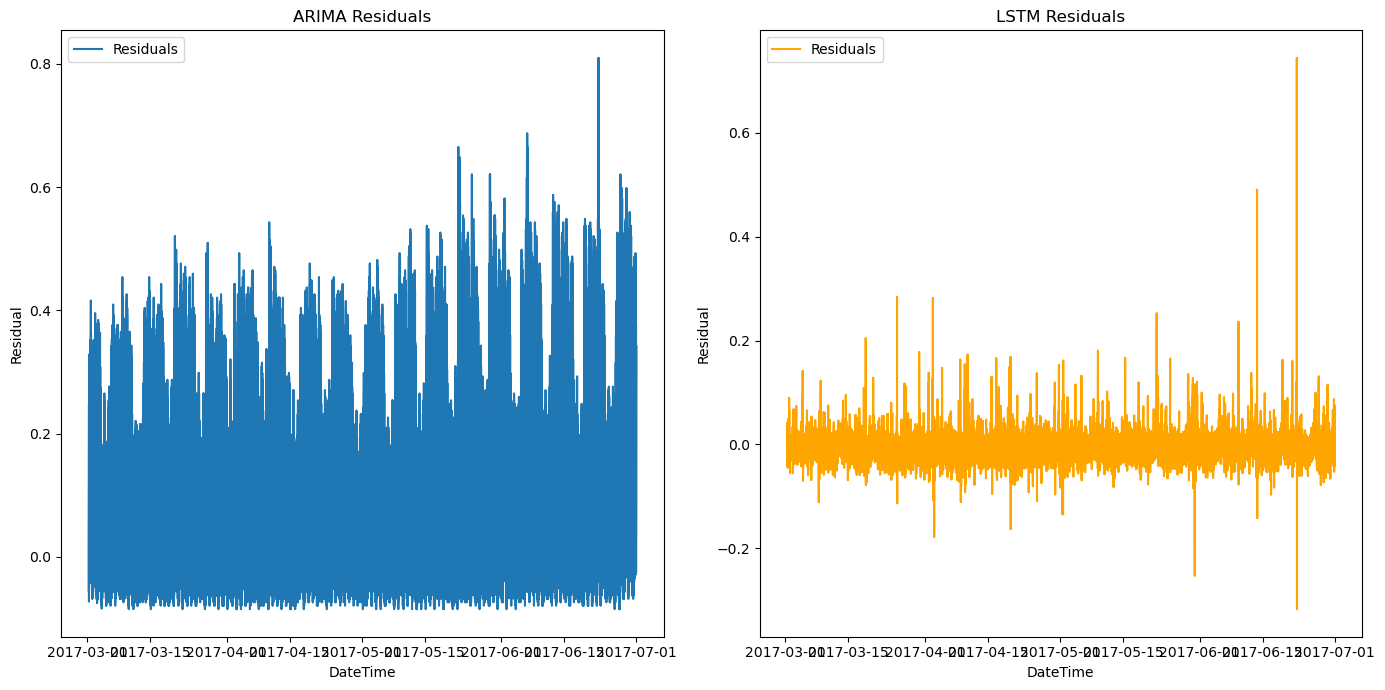

In [19]:
# For ARIMA
residuals_arima = test_data['Vehicles'] - arima_forecast

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(test_data.DateTime, residuals_arima, label='Residuals')
plt.title('ARIMA Residuals')
plt.xlabel('DateTime')
plt.ylabel('Residual')
plt.legend()

# For LSTM
residuals_lstm = y_test - lstm_predictions

plt.subplot(1, 2, 2)
plt.plot(test_data.DateTime[-len(residuals_lstm):], residuals_lstm, label='Residuals', color='orange')
plt.title('LSTM Residuals')
plt.xlabel('DateTime')
plt.ylabel('Residual')
plt.legend()

plt.tight_layout()
plt.show()


Error Distribution Charts

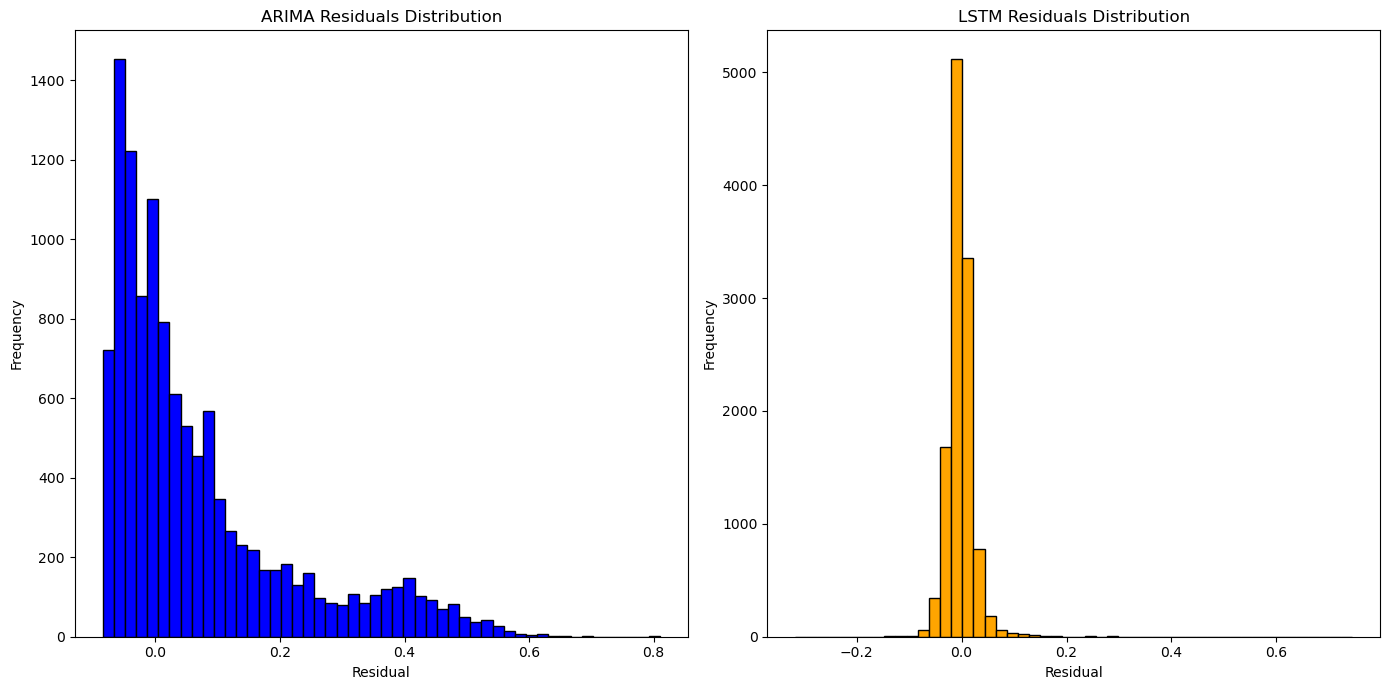

In [20]:
plt.figure(figsize=(14, 7))

# For ARIMA
plt.subplot(1, 2, 1)
plt.hist(residuals_arima, bins=50, color='blue', edgecolor='black')
plt.title('ARIMA Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')

# For LSTM
plt.subplot(1, 2, 2)
plt.hist(residuals_lstm, bins=50, color='orange', edgecolor='black')
plt.title('LSTM Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


From the visualizations, we can further confirm that the LSTM model performed way better and was more accurate than the ARIMA model. 

A well-performing model should have residuals centered around zero, ideally following a normal distribution. Skewness or heavy tails might indicate areas where the model could be improved. Unlike ARIMA, the LSTM residuals are randomly scattered around zero. This indicates that the model is capturing the patterns in the data effectively without systematic bias.

The closer the predicted values are to the actual values, the better the model performance. The LSTM plot showed predicted values closely following the actual values.

## Cross Validation

In [21]:
df.set_index('DateTime', inplace=True)

FOR ARIMA

In [22]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

mae_scores = []
rmse_scores = []

for train_index, test_index in tscv.split(df):
    train, test = df.iloc[train_index], df.iloc[test_index]
    model = ARIMA(train['Vehicles'], order=(5, 1, 0))
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=len(test))
    
    mae = mean_absolute_error(test['Vehicles'], predictions)
    rmse = np.sqrt(mean_squared_error(test['Vehicles'], predictions))
    
    mae_scores.append(mae)
    rmse_scores.append(rmse)

print(f"ARIMA Cross-Validation MAE: {np.mean(mae_scores)}, RMSE: {np.mean(rmse_scores)}")

ARIMA Cross-Validation MAE: 0.08912539415893403, RMSE: 0.11980278924126822


FOR LSTM

In [23]:
df_lstm = df.drop(columns=['Junction', 'Event_Name', 'Event_Type'])

In [24]:
df_lstm

,Vehicles,Hour,Vehicles_previous_hour,Vehicles_previous_2hours,Vehicles_previous_3hours,Vehicles_previous_4hours,Vehicles_previous_5hours,Vehicles_previous_6hours,Vehicles_previous_12hours,Vehicles_previous_day,tempC,precipMM,humidity,windspeedKmph
DateTime,,,,,,,,,,,,,,
2015-11-01 00:00:00,0.083333,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.296296,0.0,0.923077,0.205128
2015-11-01 00:00:00,0.033333,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.296296,0.0,0.923077,0.205128
2015-11-01 00:00:00,0.050000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.296296,0.0,0.923077,0.205128
2015-11-01 00:00:00,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.296296,0.0,0.923077,0.205128
2015-11-01 01:00:00,0.072222,1,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.296296,0.0,0.934066,0.205128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-30 22:00:00,0.122222,22,0.088889,0.166667,0.061111,0.094444,0.088889,0.088889,0.083333,0.083333,0.370370,0.0,0.758242,0.461538
2017-06-30 23:00:00,0.433333,23,0.466667,0.500000,0.533333,0.583333,0.527778,0.500000,0.561111,0.527778,0.333333,0.0,0.780220,0.461538
2017-06-30 23:00:00,0.150000,23,0.161111,0.172222,0.194444,0.188889,0.188889,0.177778,0.155556,0.200000,0.333333,0.0,0.780220,0.461538


In [25]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 24 

X, y = create_sequences(df_lstm.values, seq_length)

In [ ]:
# Time series split for cross-validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

mae_scores = []
rmse_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(best_params['units'], activation='relu', input_shape=(seq_length, X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # Train the model
    model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
    
    # Predict
    predictions = model.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    
    mae_scores.append(mae)
    rmse_scores.append(rmse)

print(f"LSTM Cross-Validation MAE: {np.mean(mae_scores)}, RMSE: {np.mean(rmse_scores)}")

304/304 [==============================] - 3s 8ms/step


In [ ]:
# Compile results into a dataframe

cv_results = pd.DataFrame({
    'Fold': range(1, n_splits + 1),
    'MAE': mae_scores,
    'RMSE': rmse_scores
})

cv_results

Lets visualize these findings

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# MAE Plot
axes[0].plot(cv_results['Fold'], cv_results['MAE'], marker='o', linestyle='--')
axes[0].set_title('Cross-Validation MAE')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('MAE')

# RMSE Plot
axes[1].plot(cv_results['Fold'], cv_results['RMSE'], marker='o', linestyle='--')
axes[1].set_title('Cross-Validation RMSE')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('RMSE')

plt.tight_layout()
plt.show()


The MAE values are fairly consistent across different folds, ranging from approximately 0.015 to 0.019. This suggests that the model performs reliably across different subsets of data, with only minor variations. The RMSE values also show relatively consistent performance, ranging from approximately 0.023 to 0.027. Similar to MAE, the consistency in RMSE indicates stable model performance across different data folds.

Lower MAE values generally indicate that, on average, the model's predictions are closer to the actual values. The best MAE is 0.0151, which is quite good, reflecting relatively accurate predictions on average. RMSE is more sensitive to outliers than MAE due to the squaring of errors. The RMSE values here suggest that while the model performs well overall, there are occasional larger errors, as reflected by the slight increase in RMSE compared to MAE.


Both MAE and RMSE show a general pattern of decreasing and then slightly increasing, suggesting that the model's performance might be slightly better in the middle folds but with no drastic improvements or declines.

The variance between the best and worst scores is relatively small, which indicates that the model's performance is stable and not highly dependent on the specific data split.

Since the model performs consistently across folds, overfitting is less of a concern here. If there was significant overfitting, there would be much lower errors in the training data compared to the cross-validation folds.


The model shows consistent and reliable performance across different folds of cross-validation. The errors are reasonably low, indicating that the model effectively predicts traffic congestion levels. The minor fluctuations in MAE and RMSE suggest the model is stable but could still be fine-tuned or improved with additional features or different algorithms. These results reflect a well-performing model that generalizes well to unseen data.

## Model Issues

Given the consistent MAE and RMSE values across folds, the model appears to be performing stably. 

The consistency of MAE and RMSE across folds indicates that the model does not exhibit high variance. This suggests that it generalizes well across different data splits

Residual Analysis

In [ ]:
predictions = model.predict(X_test)
predictions = pd.Series([i[0] for i in predictions.tolist()])
residuals = y_test - predictions

# Plotting residuals
plt.figure(figsize=(12, 6))
plt.scatter(predictions, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

The presence of very few outliers implies that most of the predictions are close to the actual values, and there are few significant deviations. This is a positive sign, suggesting that the model is generally accurate.

The thick horizontal scatterplot in the residuals plot suggests that the model’s errors are relatively consistent across the range of predicted values. This indicates that the model is making errors of similar magnitude, which could imply that it is not particularly sensitive to the input features' variation.


Error Distribution

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

A normal distribution of errors around zero is generally a good sign and indicates that the model’s predictions are unbiased.

Errors centered around zero suggest that the model’s predictions are, on average, accurate. The model doesn’t systematically overestimate or underestimate the traffic congestion levels. This also means that deviations from the actual values are random rather than systematic. This is desirable because it indicates that the model has captured the underlying data patterns well and that deviations are likely due to inherent randomness in the data.

Lets analyze errors by time

In [ ]:
df_test = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions.values.flatten(),
    'Error': residuals,
    'Time': df_lstm.index[test_index]
})

# Plot error over time
plt.figure(figsize=(12, 6))
plt.plot(df_test['Time'], df_test['Error'])
plt.title('Error over Time')
plt.xlabel('Time')
plt.ylabel('Error')
plt.show()


Spikes in errors might suggest that there are anomalies or outliers in the data that the model is struggling to handle. These spikes could be related to rare events, data quality issues, or sudden changes in traffic patterns. If the spikes are random and do not correlate with specific time periods or features, they may be due to random noise.

## Refine Feature Engineering

Lets add some new features to the data

In [ ]:
df['Day_of_Week'] = df.index.dayofweek
df['Month'] = df.index.month
df['Hour'] = df.index.hour
df['Is_Weekend'] = df.index.dayofweek >= 5
df['Is_Peak_Hour'] = df.index.hour.isin([7, 8, 17, 18])

df

In [ ]:
df = df.rename(columns = {'Vehicles_previous_day':'Vehicles_previous_24hours'})

Lets calculate rolling statistics to capture trends and variations.

In [ ]:
df['Rolling_Mean_24hours'] = df['Vehicles'].rolling(window=24).mean()
df['Rolling_Std_24hours'] = df['Vehicles'].rolling(window=24).std()

Lets create a feature that explores interactions between weather conditions and traffic patterns

In [ ]:
df['Temp_Humidity_Interaction'] = df['tempC'] * df['humidity']

Lets create a binary feature indicating whether an event is occurring.

In [ ]:
df['Event_Present'] = df['Event_Name'].apply(lambda x: 1 if x != 'No events' else 0)

Lets drop the events_name and type columns

In [ ]:
df = df.drop(columns = ['Event_Name', 'Event_Type'])

In [ ]:
df.info()

In [ ]:
df.corr()

In [ ]:
correlation_matrix = df.corr().abs().round(2)

correlation_matrix

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Most of the new features we created have very low correlation with the number of vehicles at a junction.

Assess Feature Importance using Tree-Based Models

In [ ]:
X = df.drop(columns=['Vehicles']) 
y = df['Vehicles']  

train_size = int(len(df) * 0.8)

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

In [ ]:
feature_importances = model.feature_importances_

# Create a DataFrame for easy visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df.reset_index(drop=True)

From feature importance analysis, we can see that Peak hours contributes least to the number of vehicles at a junction. This is also true for events, day of week, weekends, precipitation and the the month. We will drop the 7 least useful features

In [ ]:
df = df.drop(columns = ['Is_Peak_Hour', 'Event_Present', 'Is_Weekend', 'precipMM', 'Month', 'windspeedKmph', 'Day_of_Week'])

Lets split the data into training and testing sets

In [ ]:
X = df.drop(columns=['Vehicles'])
y = df['Vehicles']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Combining Random Forest and XGBoost into an ensemble model can be an effective way to leverage the strengths of both algorithms. Lets do that.

Random Forest

Grid Search for Random Forest

In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

Initialize and Fit Grid Search

In [ ]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit Grid Search
grid_search_rf.fit(X_train, y_train)

rf_best_params = grid_search_rf.best_params_

# Best Parameters and Score
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

In [ ]:
best_rf_model = RandomForestRegressor(
    max_depth=rf_best_params['max_depth'],
    min_samples_leaf=rf_best_params['min_samples_leaf'],
    min_samples_split=rf_best_params['min_samples_split'],
    n_estimators=rf_best_params['n_estimators'],
    random_state=42
)

best_rf_model.fit(X_train, y_train)

In [ ]:
y_pred_rf = best_rf_model.predict(X_test)

XGBOOST

Define the parameter grid for XGBoost

In [ ]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


Initialize the XGBoost Regressor

In [ ]:
xgb_model = XGBRegressor(random_state=42)

# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit Grid Search
grid_search_xgb.fit(X_train, y_train)

xgb_best_params = grid_search_xgb.best_params_

# Best Parameters and Score
print("Best Parameters for XGBoost:", xgb_best_params)

In [ ]:
best_xgb_model = XGBRegressor(
    max_depth=xgb_best_params['max_depth'],
    learning_rate=xgb_best_params['learning_rate'],  
    n_estimators=xgb_best_params['n_estimators'],
    colsample_bytree=xgb_best_params['colsample_bytree'],  
    subsample=xgb_best_params['subsample'],
    random_state=42
)

best_xgb_model.fit(X_train, y_train)

y_pred_xgb = best_xgb_model.predict(X_test)

Get the average prediction of the two models

In [ ]:
y_pred_ensemble_avg = (y_pred_rf + y_pred_xgb) / 2

Lets evaluate the ensemble

In [ ]:
mae_ensemble_avg = mean_absolute_error(y_test, y_pred_ensemble_avg)
rmse_ensemble_avg = mean_squared_error(y_test, y_pred_ensemble_avg, squared=False)

print(f'Ensemble (Averaging) MAE: {mae_ensemble_avg}')
print(f'Ensemble (Averaging) RMSE: {rmse_ensemble_avg}')

VISUALIZATION

To visualize the performance of the ensemble models, let's plot the actual vs. predicted values over time.

In [ ]:
results_df_ensemble = pd.DataFrame({
    'Actual': y_test,
    'Predicted_Ensemble_Avg': y_pred_ensemble_avg,
}).reset_index().sort_values(by='DateTime')

results_df_ensemble.head()

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(results_df_ensemble['DateTime'], results_df_ensemble['Actual'], label='Actual', color='blue')
plt.plot(results_df_ensemble['DateTime'], results_df_ensemble['Predicted_Ensemble_Avg'], label='Predicted Ensemble (Averaging)', color='purple', linestyle='--')
plt.xlabel('DateTime')
plt.ylabel('Traffic Congestion')
plt.title('Actual vs. Predicted Traffic Congestion Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The ensemble model using simple averaging shows promising results with an MAE of 0.0166 and an RMSE of 0.0259. These metrics indicate that the ensemble model is performing well, likely better than the earlier LSTM models.

An MAE of 0.0166 suggests that, on average, the ensemble model's predictions are off by about 0.0166 units. This low value indicates high accuracy.
An RMSE of 0.0259 indicates that the standard deviation of the prediction errors is low, further confirming the model's accuracy.
